# TTN to MTTN
## Input: Temporal text network created in file 'csv_to_ttn'
## Output: Multilayer Temporal text network, where layers represent sentiment and social dimensions of messages

In [1]:
import uunet.multinet as ml
import pandas as pd
import tendims
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# load ten dimensions classifier
model = tendims.TenDimensionsClassifier(is_cuda=True, models_dir = './models/lstm_trained_models', 
                                        embeddings_dir='./embeddings')


Loaded word embeddings from ./embeddings\glove/glove.42B.300d.wv!
Vocab size: 1917494
Loaded word embeddings from ./embeddings\word2vec/GoogleNews-vectors-negative300.wv!
Vocab size: 3000000
Loaded word embeddings from ./embeddings\fasttext/wiki-news-300d-1M-subword.wv!
Vocab size: 999994
Torch version: 2.5.1+cpu
Torch CUDA available : False
Cuda not available. Instantiated the TenDimensionsClassifier with CUDA=False


C:\Users\Asus\Desktop\exjobb_git\tendims.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state = torch.load(join(self.models_dir, modelname), map_location='cpu')


In [3]:
def initialise_10d_ttn(ttn, dimensions):
    '''
    loads person/messages ttn and adds one layer for each dimension
    '''
    
    # add layers to network
    ml.add_layers(ttn, dimensions)
    
    # direct edges
    dir_ = { "layer1": ["persons"]*len(dimensions), "layer2": dimensions, "dir": [True]*len(dimensions) }
    ml.set_directed(ttn, dir_)
            
    return ttn

def add_message(message,dim,ttn,speaker,receivers):
    '''
    adds message to dim-layer
    '''
    # message name
    message_name = message # + f'_{dim}'
    # add message-vertice to dimension layer
    message_vertice = {"actor": [message_name], "layer": [dim]}
    ml.add_vertices(ttn, message_vertice)

    # add speaker-dim edges
    speaker_dim_edge = {"from_actor": [speaker], "from_layer": ['persons'], "to_actor": [message_name], "to_layer": [dim]}
    ml.add_edges(ttn, speaker_dim_edge)

    # add dim-receiver edges
    dim_receiver_edges = {"from_actor": [message_name]*len(receivers), "from_layer": [dim]*len(receivers), 
                 "to_actor": receivers, "to_layer": ['persons']*len(receivers)}
    ml.add_edges(ttn, dim_receiver_edges)
    
def fill_10d_ttn(ttn, dimensions, threshold):
    '''
    adds vertices from message layer to dimension layers
    '''
    
    # get verices and edges
    vertices = ml.vertices(ttn, layers=["messages"])
    edges = pd.DataFrame.from_dict(ml.edges(ttn))
    
    # fill 10-dim layers with messages
    for message in vertices['actor']:
    
        # get message- speaker and recievers
        speaker = edges.loc[edges['to_actor'] == message, 'from_actor'].item()
        receivers = list(edges.loc[edges['from_actor'] == message, 'to_actor'])
        #receivers = ml.get_values(ttn, "addressed", vertices={'actor': [message], 'layer':['messages']})['addressed']

        # filter recievers
        
        # get text
        text = ml.get_values(ttn, "text", vertices={'actor': [message], 'layer':['messages']})['text'][0]
                
            
        for dim in dimensions:
            # check if dim is a sentiment-dimension 
            if dim in ['positive','negative','neutral']:
    
                # get sentiment-label
                sentiment = ml.get_values(ttn, "sentiment-label", vertices={'actor': [message], 'layer':['messages']})['sentiment-label'][0]
                
                # check if message-sentiment matches sentiment-layer
                if sentiment == dim:
                    add_message(message,dim,ttn,speaker,receivers)
            else:
                # compute dimension score
                score = model.compute_score(text, dim) 
    
                # check if dimensions passes threshold
                if score >= threshold:
    
                    # add message
                    add_message(message,dim,ttn,speaker,receivers)


def test_msg(attributes,ttn,message):
    '''
    prints message data (from,to, and attributes)
    ''' 
    # print speaker --> message --> reciever
    edges = pd.DataFrame.from_dict(ml.edges(ttn))
    speaker = list(edges.loc[edges['to_actor'] == message, 'from_actor'])
    reciever = list(edges.loc[edges['from_actor'] == message, 'to_actor'])
    print('speakers --> message --> receivers:')
    print(f'{speaker} --> {message} --> {reciever}')

    # print attributes of message
    print(f'\n{message} attributes:')
    original_message = message.split('_')[0]
    vertice = {"actor": [original_message], "layer": ['messages']} # vertices for getting attributes from ttn
    for a in attributes['name']:
        value = ml.get_values(ttn, a, vertices = vertice)[a] # get value
        print(f'{a}: {value}')
                

In [4]:
# main

# "parameters"
threshold = 2/3 # dimension score threshold

# initialise 10d ttn
ttn = ml.read('data/ttn_nets/ttn.txt') # load original ttn
attributes = ml.attributes(ttn,target='vertex') # get attributes from original ttn
dimensions = model.dimensions_list + ['positive','negative','neutral'] # dimension-layers
ttn_10d = initialise_10d_ttn(ttn,dimensions) # create 10d-ttn from ttn

# fill 10d ttn
fill_10d_ttn(ttn_10d,dimensions,threshold)

# save ttn
ml.write(n = ttn_10d,file = 'data/ttn_nets/mttn.txt', format = "multilayer")
ml.write(n = ttn_10d,file = 'data/ttn_nets/mttn.graphml', format = "graphml")

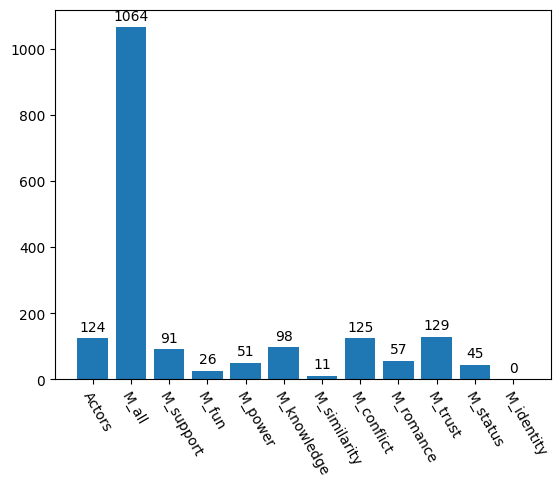

In [20]:
count = []
layers = ['persons','messages', 'support', 'fun', 'power', 'knowledge', 'similarity', 'conflict', 'romance', 'trust', 'status', 'identity']
layers = [l for l in layers if l not in ["positive","negative","neutral"]]
for layer in layers:

    n = len(ml.actors(ttn_10d, layers=[layer])["actor"])
    count.append(n)


layer_labels = ['Actors','M_all', 'M_support', 'M_fun', 'M_power', 'M_knowledge', 'M_similarity', 'M_conflict', 'M_romance', 'M_trust', 'M_status', 'M_identity']

fig, ax = plt.subplots()
p = ax.bar(layers,count)
ax.bar_label(p, padding=3)

ax.set_xticks(layers, labels=layer_labels, rotation=-60,  ha="left", rotation_mode="anchor")

print()

C:\Users\Asus\AppData\Local\Temp\ipykernel_23104\148604990.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


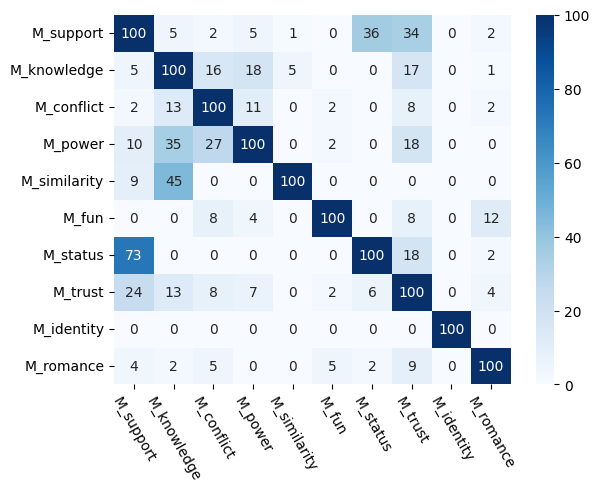

In [17]:
Ms_dim = ['M_support', 'M_knowledge', 'M_conflict', 'M_power', 'M_similarity', 'M_fun', 'M_status', 'M_trust', 'M_identity', 'M_romance']
df = pd.DataFrame(index=Ms_dim, columns=Ms_dim)
df = df.fillna(0)

dimensions = ['support', 'knowledge', 'conflict', 'power', 'similarity', 'fun', 'status', 'trust', 'identity', 'romance']
for dim1 in dimensions:
    
    nodes1 = ml.actors(ttn_10d, layers=[dim1])["actor"]

    for node in nodes1:

        for dim2 in dimensions:
            
            nodes2 = ml.actors(ttn_10d, layers=[dim2])["actor"]

            if node in nodes2:
                df.loc['M_'+dim1, 'M_'+dim2] += 1
                

matrix = df.div(df.max(),axis=0).mul(100).round()

matrix.loc['M_identity','M_identity'] = 100
matrix = matrix.fillna(0)
# plotting correlation matrix
fig, ax = plt.subplots()
sns.heatmap(matrix, cmap="Blues", ax = ax, annot=True, fmt='g')
ax.tick_params(axis='x', labelrotation=-60)

#plt.savefig(f'plots/heatmap_message_count.png',bbox_inches="tight")